## 2.8 Решение задачи предсказания результатов экзаменов учеников.

### Цель: нахождение значимых данных на успеваемость учащегося для будущего построения модели определения группы риска отстающих учеников.

#### 1. Импортируем необходимые библиотеки, загрузим датафрейм

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

# отключим вывод варнингов
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

stud_math = pd.read_csv('stud_math.csv')

#### 2. Напишем необходимые функции для обработки датафрейма

In [2]:
def get_boxplot(df, column, key_column):
    '''
    Функция предназначена для вывода графика по датафрейму с ключевой колонкой
    df - dataframe 
    column - колонка оси x
    key_column - колонка оси y
    '''
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y=key_column,
                data=df.loc[df.loc[:, column].isin(
                    df.loc[:, column].value_counts().index[:10])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


def drop_incorrect(df, column):
    '''
    Функция предназначена для очистки датасета по ключевой числовой колонке от некорректных данных 
    в виде 0, в отрицательного числа и в виде NaN или Null
    '''
    if df[column].dtype == 'float64':
        if df[column].isnull().any():
            n_rows = df[df[column].isnull()]
            df.drop(n_rows.index.tolist(), inplace=True)
        if (df[column] == 0).any():
            n_rows = df[df[column] == 0]
            df.drop(n_rows.index.tolist(), inplace=True)
        if (df[column] < 0).any():
            n_rows = df[df[column] < 0]
            df.drop(n_rows.index.tolist(), inplace=True)
        # Переопределяем индексы датафрейма
        df.index = pd.RangeIndex(1, len(df.index) + 1)


def replace_NaN(df):
    '''Функция предназначена для замены NaN на None для всех объектных колонок в датафрейме'''
    for column in df.columns:
        if df[column].dtype == 'object':
            if df[column].isnull().any():
                n_rows = df[df[column].isnull()]
                df[column] = df[column].where((pd.notnull(df[column])), None)


def check_number_Nan(df):
    '''Функция предназначена для проверки и замены None/Null на NaN для всех числовых колонок в датафрейме'''
    for column in df.columns:
        if df[column].dtype != 'object':
            if df[column].isnull().any():
                n_rows = df[df[column].isnull()]
                df[column] = df[column].where((pd.notnull(df[column])), np.nan)


def get_stat_dif(df, key_column):
    '''Функция предназначена поиска статистически значимых различий для колонок всего датафрейма'''
    list_col = []
    for column in df.columns:
        cols = df.loc[:, column].value_counts().index[:]
        combinations_all = list(combinations(cols, 2))
        for comb in combinations_all:
            if key_column != column:
                if ttest_ind(df.loc[df.loc[:, column] == comb[0], key_column],
                             df.loc[df.loc[:, column] == comb[1], key_column]).pvalue \
                        <= 0.05/len(combinations_all):  # Учли поправку Бонферони
                    print('Найдены статистически значимые различия для колонки', column)
                    get_boxplot(df, column, key_column)
                    list_col.append(column)
                    break
    return list_col


def filter_all_blowout(df):
    for column in df:
        if df[column].dtype != 'object' and str(column) != 'failures':

            # Автоматизация IQR
            df_column = pd.DataFrame(df[column])

            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1

            # Фильтруем значения по формуле Q1-1.5 IQR and Q3+1.5 IQR
            filtered = df.query(
                '(@Q1 - 1.5 * @IQR) <= {} <= (@Q3 + 1.5 * @IQR)'.format(column))
            df[column] = pd.DataFrame(filtered[column])

#### 3. Ознакомимся с колонками и данными, обработаем

In [3]:
stud_math.head(20)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


In [4]:
stud_math.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Видим что колонка 20  "studytime, granular" имеет некорректное имя, изменим для удобства.

In [5]:
# Переименуем неудобную колонку
stud_math.rename(columns={'studytime, granular': 'studytime_g'}, inplace=True)

Ключевая колонка 'score' содержит меньше значений чем всего строк в ДФ, исправим.

In [6]:
drop_incorrect(stud_math, 'score')  # Очистим ДФ по ключевой колонке score

Так же видим что и в остальных колонках много NaN/Null вхождений, исправим заменой на None только в object колонках
поскольку использовать не NaN в числовых колонках не выйдет

In [7]:
replace_NaN(stud_math)  # Меняем NaN на None

Проверим что у нас все числовые колонки содержат вместо пустот NaN значения.

In [8]:
check_number_Nan(stud_math)

Посмотрим на распределение после обработки

,age,Medu,Fedu,traveltime,studytime,failures,studytime_g,famrel,freetime,goout,health,absences,score
count,352.000000,350.000000,331.000000,329.000000,345.000000,332.000000,345.000000,328.000000,344.000000,346.000000,339.000000,342.000000,352.000000
mean,16.633523,2.811429,2.658610,1.428571,2.046377,0.271084,-6.139130,3.942073,3.235465,3.086705,3.516224,8.090643,57.755682
std,1.256011,1.091192,2.324066,0.690907,0.840919,0.667779,2.522758,0.921871,1.004258,1.091998,1.412812,24.704600,16.200928
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-12.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,20.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,-6.000000,4.000000,3.000000,2.000000,3.000000,2.000000,45.000000
50%,17.000000,3.000000,3.000000,1.000000,2.000000,0.000000,-6.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,-3.000000,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000
max,22.000000,4.000000,40.000000,4.000000,4.000000,3.000000,-3.000000,5.000000,5.000000,5.000000,5.000000,385.000000,100.000000


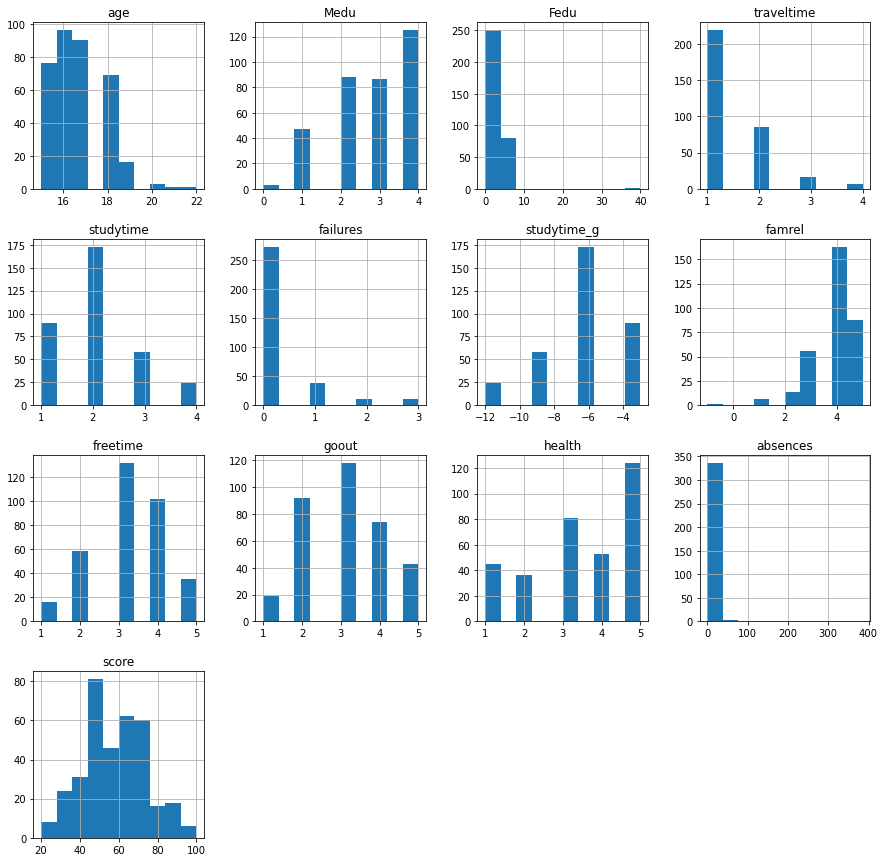

In [9]:
stud_math.hist(figsize=(15, 15))
stud_math.describe()

Как видно из распределения (и от части известно из задания) колонки 'Fedu' и 'absences' имеют максимальное распределение в меньшем диапазоне оценок (в левой части гистограммы), для 'Fedu' в диапазоне от min = 0.0 и 75% = 3.0 и 'absences' от min = 0.0 и до 75% = 8.0

Здесь явно имеются выбросы, вернемся к ним чуть позже.

Так же у нас очень похожи гистограммы studytime_g и studytime с зеркальным распределением в разных диапазонах что видно на гистограмме. Проверим корреляцию этих колонок.

In [10]:
df = stud_math.loc[:, ['studytime', 'studytime_g']]
df.corr()

,studytime,studytime_g
studytime,1.0,-1.0
studytime_g,-1.0,1.0


Так же можно вывести тепловую карту для определения остальных скоррелированых колонок.

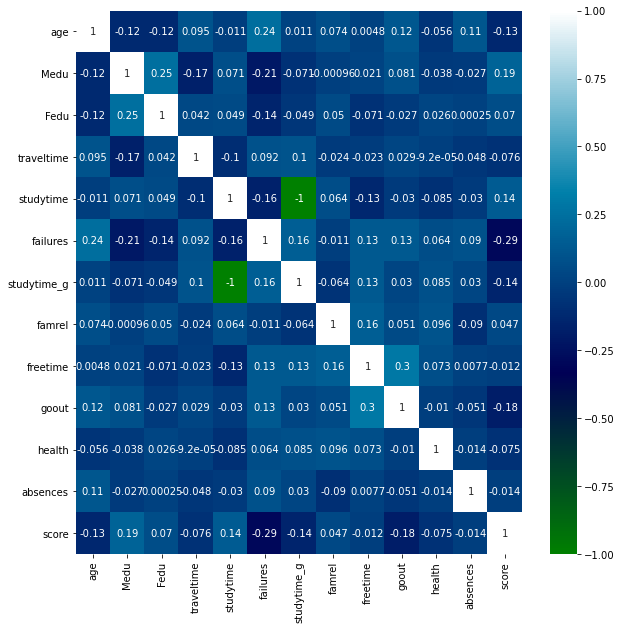

In [11]:
sns.heatmap(stud_math.corr(), annot=True, cmap='ocean')
fig = plt.gcf()
fig.set_size_inches(10, 10)

Как видно из анализа колонки 'studytime' и 'studytime_g' полности скоррелированы что говорит нам о полной идентичности данных которые были сдвинуты в отрицательную сторону, поэтому избавимся от одной (от той что мы переименовали)

In [12]:
stud_math.drop(['studytime_g'], axis='columns', inplace=True)

Самое время рассмотреть номинативные переменные

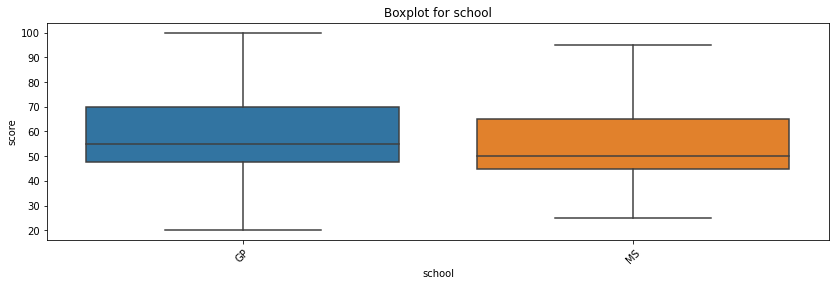

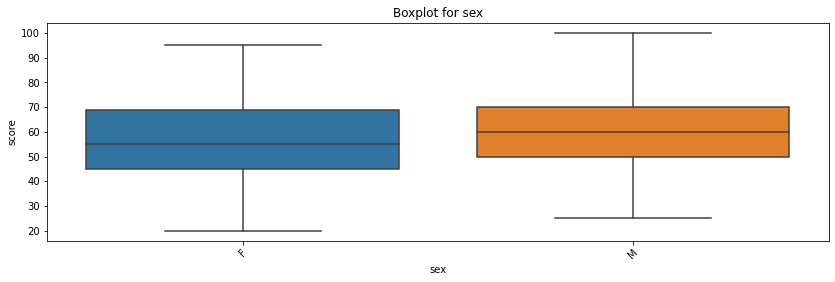

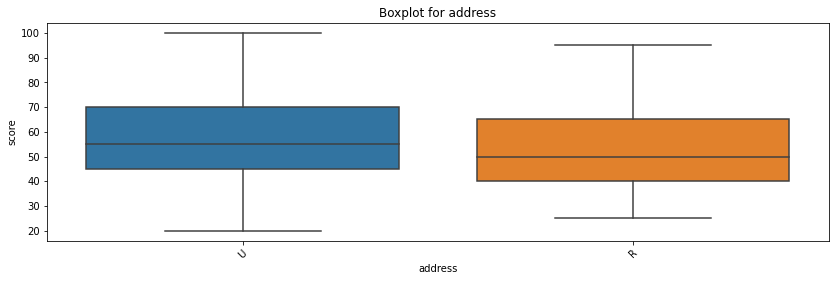

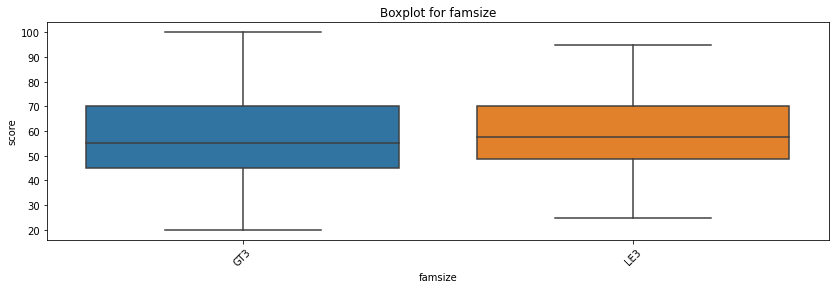

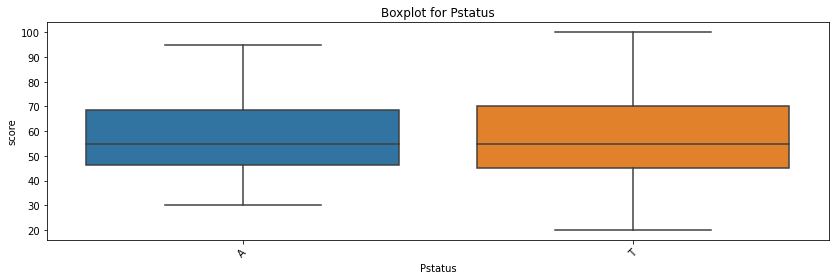

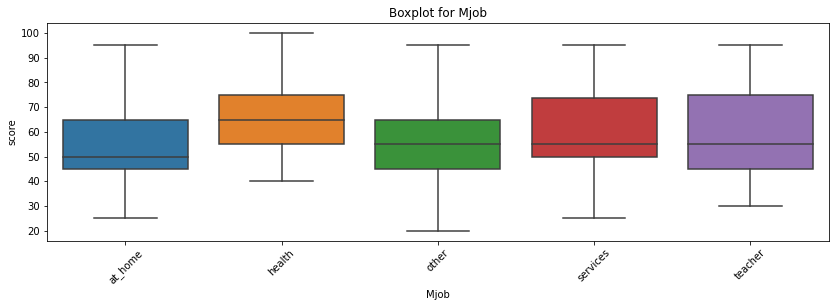

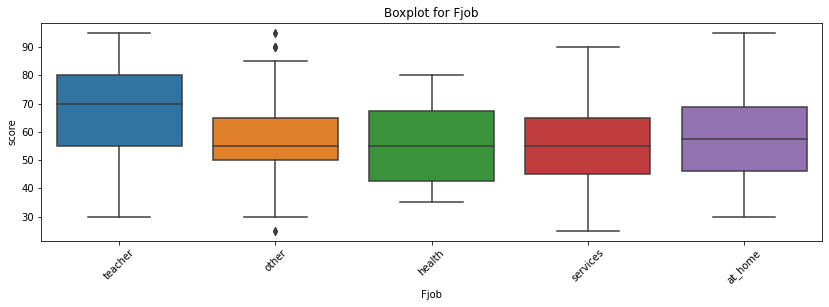

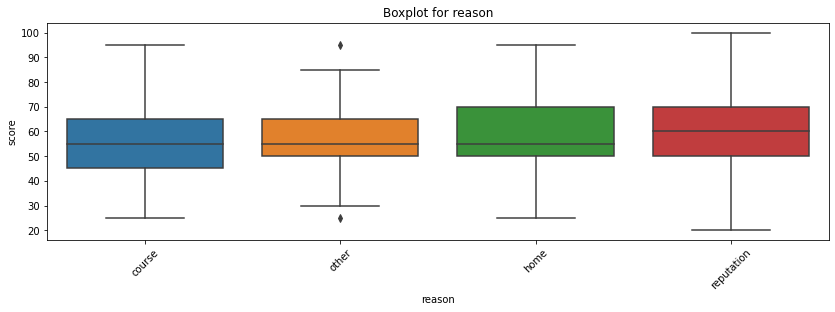

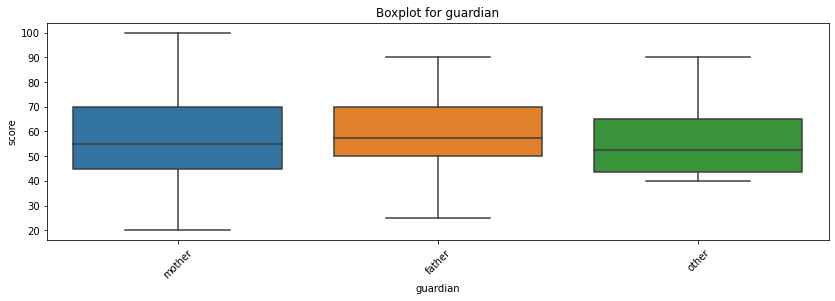

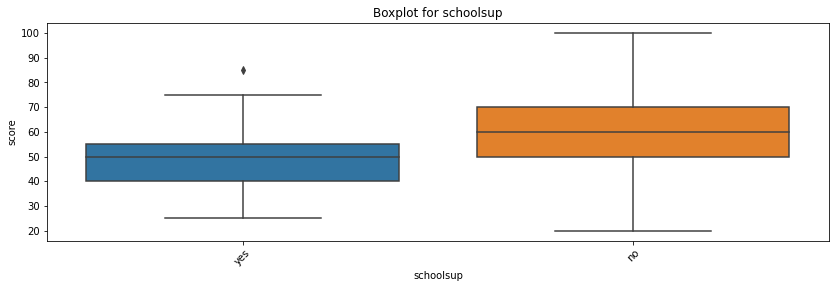

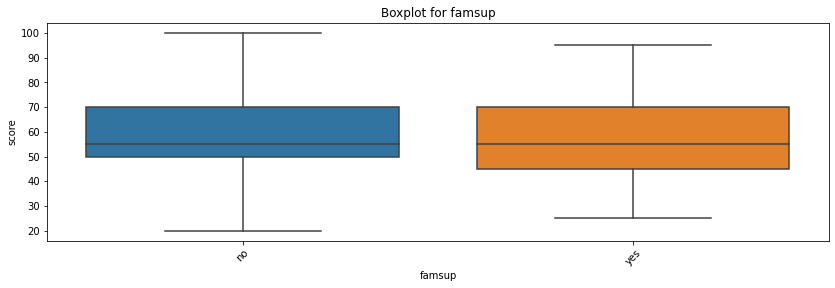

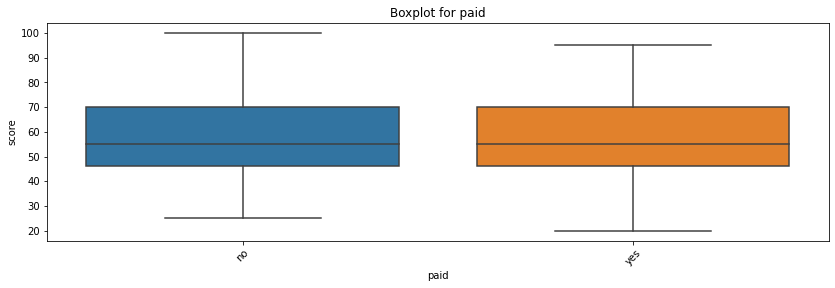

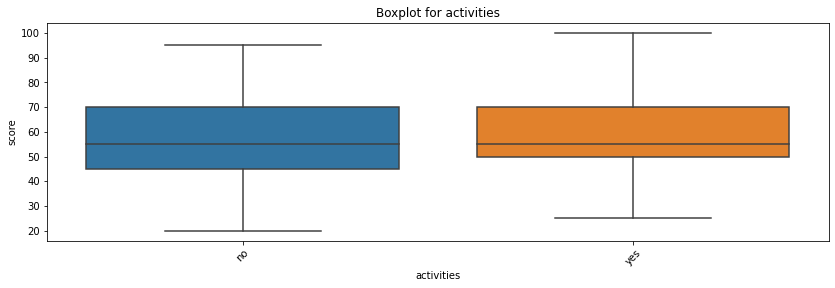

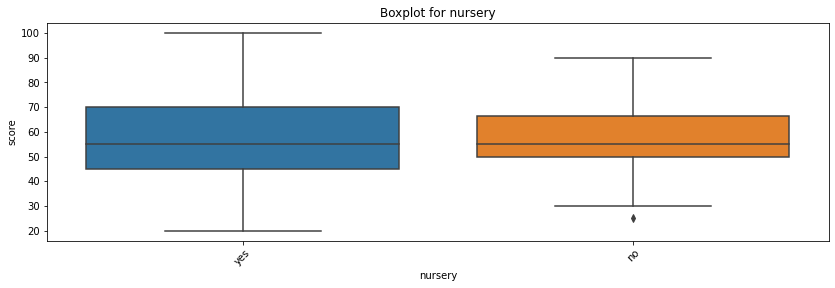

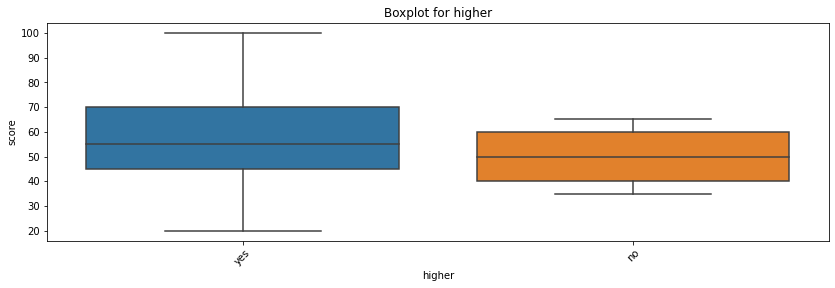

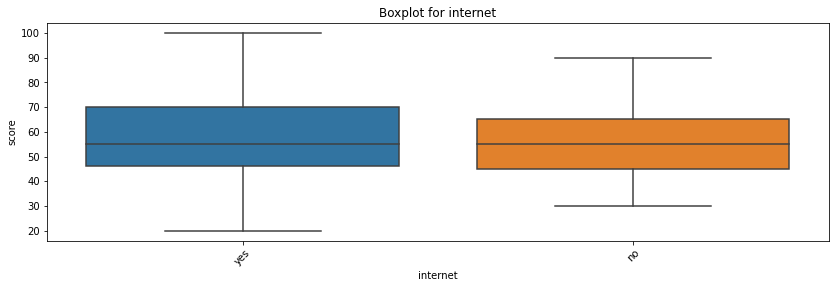

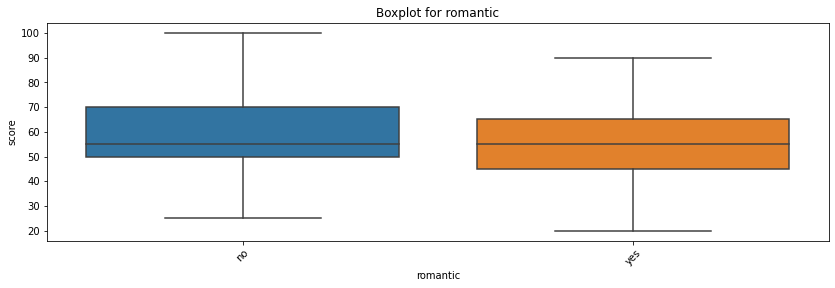

In [13]:
for col in stud_math.columns:
    if stud_math[col].dtype == 'object':
        get_boxplot(stud_math, col, 'score')

По графикам видно что у нас имеются колонки влияющие на оценки учащегося вроде Mjob, Fjob и нескольких других

Далее создадим копию и обработаем выбросы по формуле интерквартильного расстояния для того что бы иметь возможность сравнить работы двух похожих моделей и точно определить зависимые колонки и значимые различия

In [14]:
stud_math_model_2 = stud_math.copy()
filter_all_blowout(stud_math_model_2)

Обработаем модель 1 (Оригинальный датафрейм student_math) по всем её колонкам и выявим значимые, сразу просмотрев на зависимости оценок от данных в колонке

Найдены статистически значимые различия для колонки address


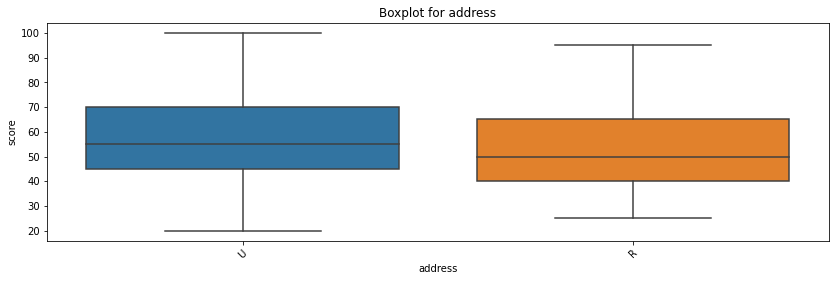

Найдены статистически значимые различия для колонки Medu


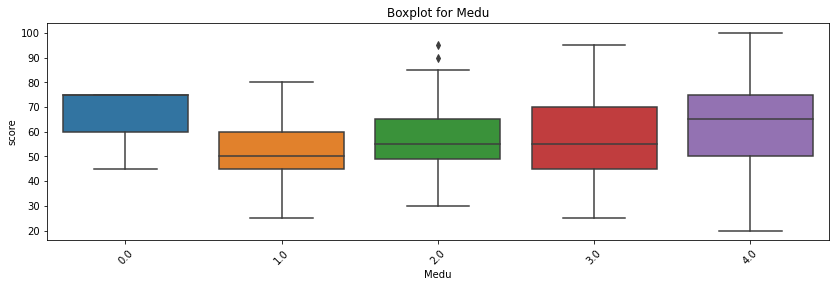

Найдены статистически значимые различия для колонки Mjob


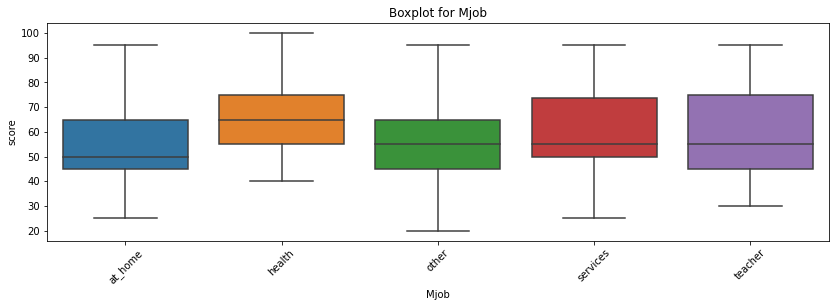

Найдены статистически значимые различия для колонки Fjob


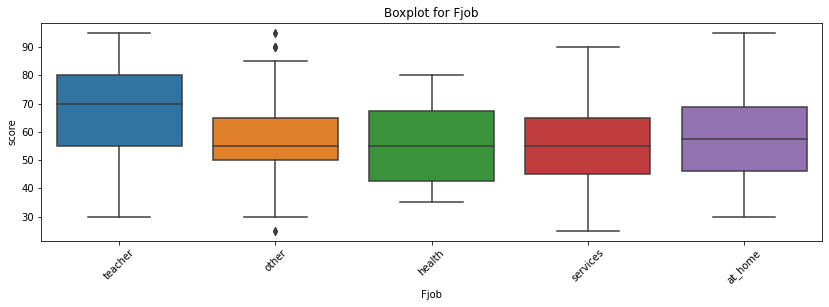

Найдены статистически значимые различия для колонки studytime


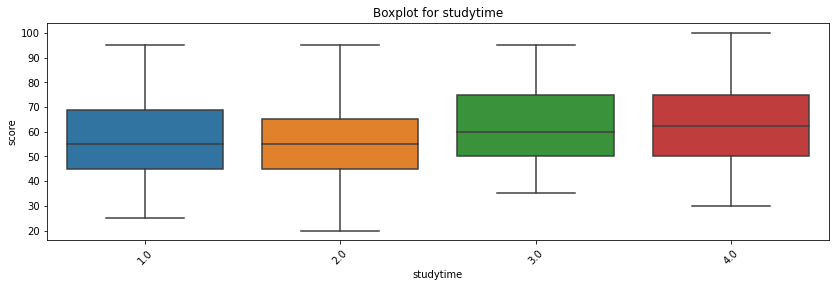

Найдены статистически значимые различия для колонки failures


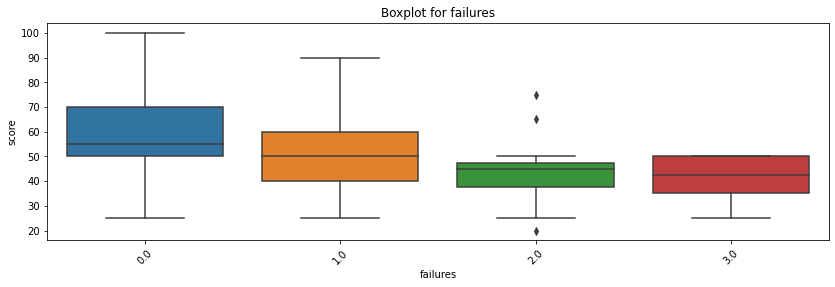

Найдены статистически значимые различия для колонки schoolsup


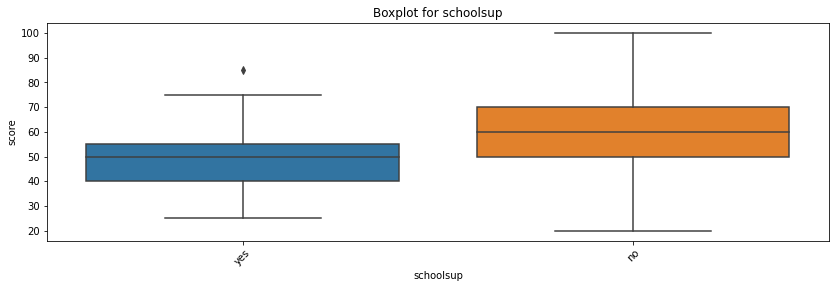

Найдены статистически значимые различия для колонки goout


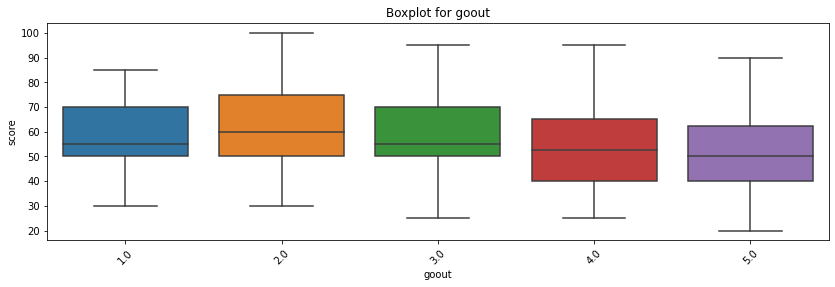

In [15]:
list_col_model_1 = get_stat_dif(stud_math, 'score')

Узнаем количество значимых колонок оригинальной модели

In [16]:
print('Значимые колонки оригинальной модели',
      list_col_model_1, 'в количестве', len(list_col_model_1))

Значимые колонки оригинальной модели ['address', 'Medu', 'Mjob', 'Fjob', 'studytime', 'failures', 'schoolsup', 'goout'] в количестве 8


Обработаем модель 2 (Копия датафрейма student_math) по всем её колонкам и выявим значимые, сразу просмотрев на зависимости оценок от данных в колонке

Найдены статистически значимые различия для колонки address


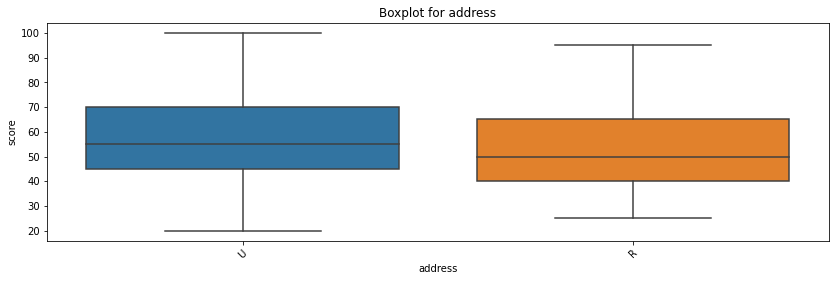

Найдены статистически значимые различия для колонки Medu


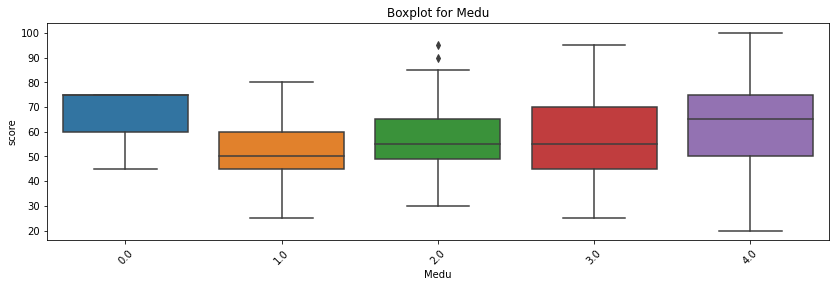

Найдены статистически значимые различия для колонки Fedu


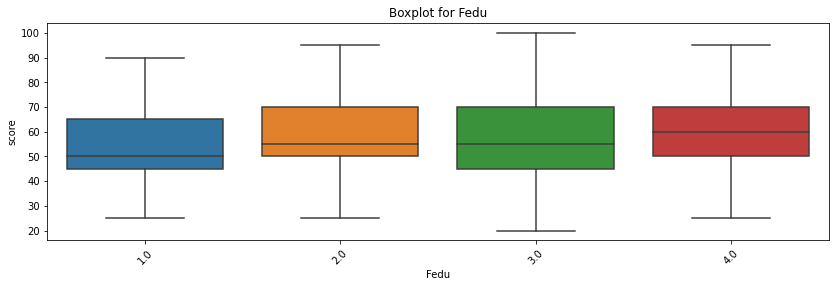

Найдены статистически значимые различия для колонки Mjob


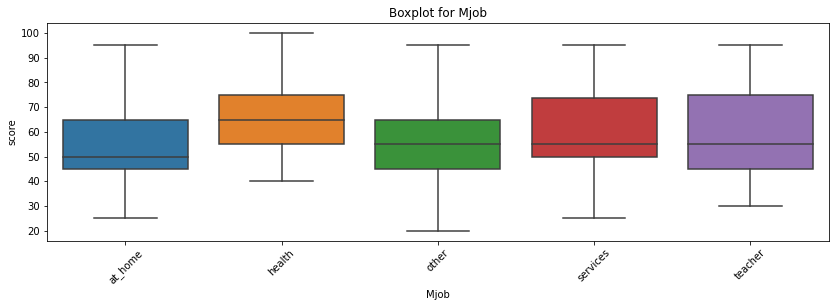

Найдены статистически значимые различия для колонки Fjob


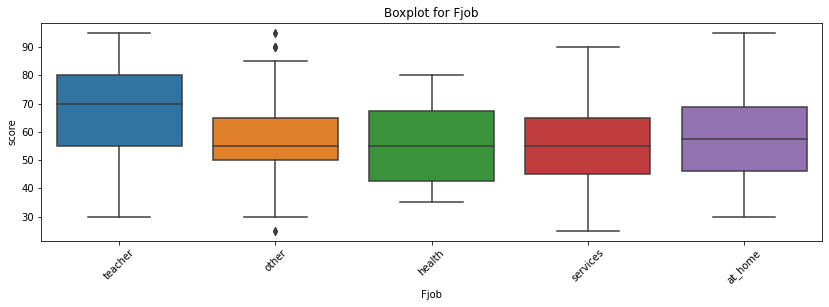

Найдены статистически значимые различия для колонки studytime


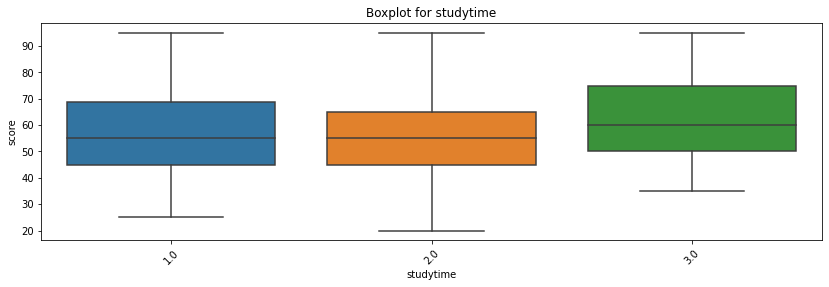

Найдены статистически значимые различия для колонки failures


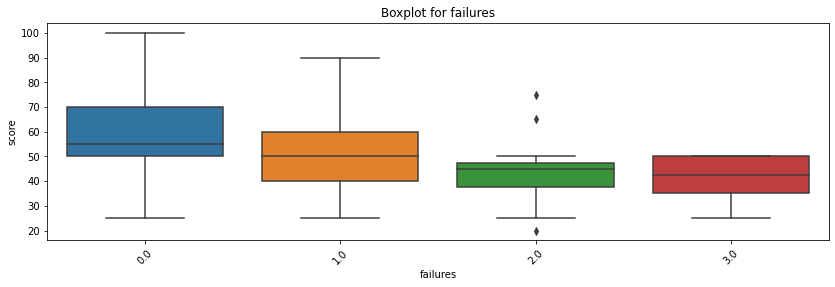

Найдены статистически значимые различия для колонки schoolsup


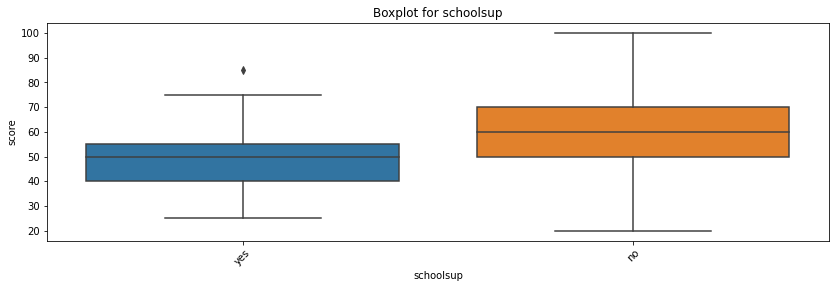

Найдены статистически значимые различия для колонки goout


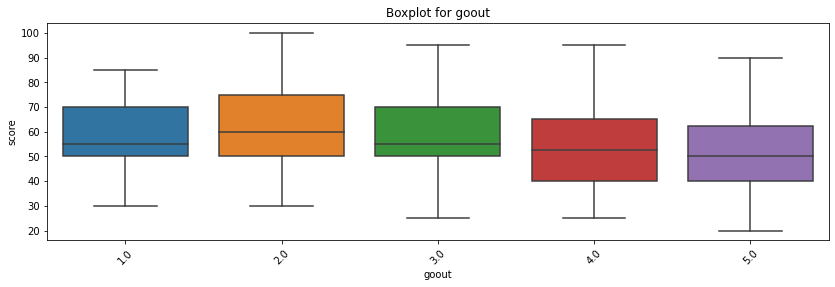

In [17]:
list_col_model_2 = get_stat_dif(stud_math_model_2, 'score')

Узнаем количество значимых колонок оригинальной модели

In [18]:
print('Значимые колонки модели 2', list_col_model_2,
      'в количестве', len(list_col_model_2))

Значимые колонки модели 2 ['address', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'studytime', 'failures', 'schoolsup', 'goout'] в количестве 9


И так у нас получилось 2 очень похожие модели в которых есть по 8 похожих значимых колонок которые и можно использовать для дальнейшего построения модели.

In [19]:
print('Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, это:',
      set(list_col_model_2) & set(list_col_model_1))

Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, это: {'address', 'Mjob', 'studytime', 'Medu', 'schoolsup', 'Fjob', 'failures', 'goout'}


### Основные итоги работы.

В данных много пустых значений и мной впринципе не производилось заполнение столбцов какими либо данными кроме замены значений.
Так же имелись и выбросы которые в свою очередь полностью повлияли на одну из колонок.

Очевидно что 8 исключительных колонок выше явно влияют на показатели обучающихся, думаю что колонка Fedu в достаточно большой степени так же могла влиять на оценку учеников и её можно было оставить. Как мне кажется образование Отца сильно повлияет на его ребенка и его успеваемость.

Самые важные для модели данные будут находиться в данных колонках 'address', 'Mjob', 'studytime', 'Medu', 'schoolsup', 'Fjob', 'failures', 'goout'
